# Differentiable FIR Filters

In this chapter, we will implement differentiable FIR filters, and optimise their parameters. To start, we make the necessary imports, set some useful globals, seed the PRNG, and define a handful of utility functions.

In [1]:
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
SAMPLE_RATE = 16000
EPSILON = 1e-7

SEED = 420
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
def safe_log(x: Union[np.ndarray, torch.Tensor], base: Optional[float] = None, eps: float = EPSILON):
    if isinstance(x, np.ndarray):
        denom = 1 if base is None else np.log(base)
        return np.log(np.clip(x, eps, None)) / denom
    elif isinstance(x, torch.Tensor):
        denom = 1 if base is None else torch.log(base)
        return torch.log(torch.clamp(x, min=eps)) / denom
    
def plot_signal_and_spectrum(signal: torch.Tensor):
    """We'll be wanting to plot some signals, so let's make that nice and easy...
    """
    signal = signal.detach().numpy()

    # compute the log magnitude spectrum of the signal
    spectrum = np.fft.rfft(signal, norm="forward")
    spectrum = np.abs(spectrum)
    spectrum = 20 * safe_log(spectrum, 10)

    fig, ax = plt.subplots(2, 1, figsize=(6, 4))
    t = np.arange(signal.size) / SAMPLE_RATE
    ax[0].plot(t, signal, color="black", linewidth=0.5)
    ax[0].set_title("Signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    f = SAMPLE_RATE * np.arange(signal.size // 2 + 1) / signal.size
    ax[1].plot(f, spectrum, color="black", linewidth=0.5)
    ax[1].set_xscale("log")
    ax[1].set_title("Spectrum")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("Magnitude (dB)")

    fig.tight_layout()

BODE_PLOT_COLORS = ["black", "red", "green", "blue", "orange"]
BODE_PLOT_LINESTYLES = ["solid", "dashed", "dotted", "dashdot"]

def bode_plot(
    impulse_response: Union[torch.Tensor, list[torch.Tensor]],
    N: int,
    labels: Optional[list[str]] = None
):
    """We'll be wanting to look at some filters too... so let's make some Bode plots
    """

    if not isinstance(impulse_response, list):
        impulse_response = [impulse_response]
    hs = [i.detach().numpy() for i in impulse_response]

    # evaluate the z-transform at roots of unity by zero padding the impulse
    # response and taking the DFT
    hs_ = [np.pad(h, (0, N - h.size)) for h in hs]
    Hs = [np.fft.rfft(h_)[:-1] for h_ in hs_]
    
    H_mags = [np.abs(H) for H in Hs]
    H_mags = [20 * safe_log(H_mag, 10) for H_mag in H_mags]
    
    H_phases = [np.angle(H) for H in Hs]

    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    f = SAMPLE_RATE * np.arange(N // 2) / N

    if labels is None:
        labels = [None] * len(hs)
    
    for H_mag, H_phase, h, label, color, linestyle in zip(
        H_mags, H_phases, hs, labels, BODE_PLOT_COLORS, BODE_PLOT_LINESTYLES
    ):
        ax[0].plot(f, H_mag, linewidth=1.0, label=label, color=color, linestyle=linestyle)
        ax[0].set_xscale("log")
        ax[0].set_title("Magnitude")
        ax[0].set_xlabel("Frequency (Hz)")
        ax[0].set_ylabel("dB")
        
        ax[1].plot(f, H_phase, linewidth=1.0, label=label, color=color, linestyle=linestyle)
        ax[1].set_xscale("log")
        ax[1].set_title("Phase")
        ax[1].set_xlabel("Frequency (Hz)")
        ax[1].set_ylabel("radians")
        
        _, stem, _ = ax[2].stem(h, basefmt="black", label=label, linefmt=color)
        plt.setp(stem, "linewidth", 1.0)
        plt.setp(stem, "linestyle", linestyle)
        ax[2].set_title("Impulse Response")
        ax[2].set_xlabel("Sample Index")
        ax[2].set_ylabel("Amplitude")
        fig.tight_layout()

    if any([l is not None for l in labels]):
        ax[0].legend()

## `nn.Conv1D` $\approx$ FIR

As we have discussed, applying a discrete time FIR filter to a signal is equivalent to convolving the signal $x[n]$ with the impulse response of the filter $h[n]$:

$$
y[n] = (x\ast h)[n] = \sum_{m=-\infty}^\infty x[n-m]h[m].
$$

Of course, neither our impulse response nor our signal is infinitely long, meaning they are implicitly padded by zeros and we can truncate the sum. Let us assume that our impulse response has length $M$, then our signal $y[n]$ is given by:

$$
y[n] = \sum_{m=0}^M x[n-m]h[m].
$$

This, you might notice, is very close to the way that 1D convolutional layers are computed in neural networks\*. So close, in fact, that convolutional layers effectively _are_ differentiable FIR filters!

\* Confusingly, these layers perform *cross-correlation* instead of convolution, which is very similar but the impulse response (which, in this context, is referred to as a kernel) is reversed. In fact, if we swap $x[n-m]$ for $x[n+m]$, we have a 1D convolutional layer.

Let's start by exploring this connection a little and creating some very simple FIR filters. First, some imports, useful globals, and a couple of utilities:

We start by creating a white noise signal $x$ of length $N$:

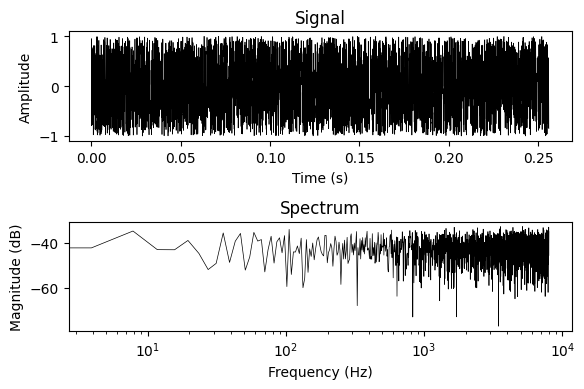

In [4]:
N = 4096
x = torch.empty(N).uniform_(-1, 1)
plot_signal_and_spectrum(x)

Now let's create a very simple filter, the one given by the difference equation:

$$
y[n] = x[n] + x[n-1] + x[n-2].
$$

This is a simple moving average filter, which attenuates the high frequencies. It is equivalent to the impulse response: $\mathbf{h} = \begin{bmatrix}1 & 1 & 1\end{bmatrix}^T$.

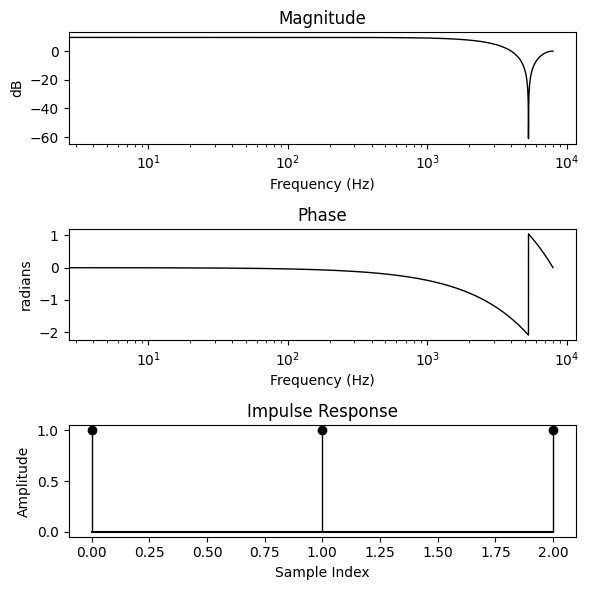

In [5]:
h = torch.tensor([1.0, 1.0, 1.0])

bode_plot(h, N)

We will now use PyTorch's `nn.functional.conv1d` to apply our impulse response (aka kernel) to our signal. Note that [this function expects](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html) an input tensor with the shape `[batch, in_channels, time]`, and a kernel tensor with shape `[out_channels, in_channels, length]`. Now, as we are operating with a batch size of 1, and on only a single channel, we will just add placeholder dimensions.

In [6]:
x_ = x[None, None, :]  # unsqueeze to [batch, in_channels, time]
h_ = h[None, None, :]  # unsqueeze to [out_channels, in_channels, length]

print(f"input shape: {x_.shape}\nkernel shape: {h_.shape}")

input shape: torch.Size([1, 1, 4096])
kernel shape: torch.Size([1, 1, 3])


Our tensors are correctly shaped... let's perform the convolution! Note that we call `torch.Tensor.flip()` in order to reverse the impulse response. This makes the `nn.functional.conv1d`'s cross-corelation operation into a convolution.

In [7]:
y_ = nn.functional.conv1d(
    x_,
    h_.flip(-1),
    padding="same"
)
y = y_.squeeze()

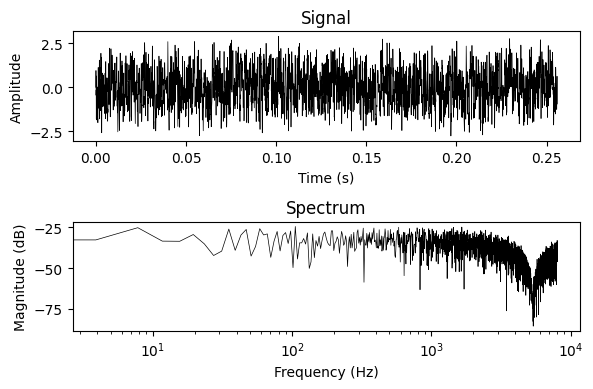

In [8]:
plot_signal_and_spectrum(y)

### Optimising our simple FIR filter

Now, let's try to optimise the impulse response of our direct convolution filter so that it matches a target filter's response. To do so, let's first wrap our filtering code in a nice tidy function:

In [9]:
def apply_conv1d_fir(input_signal: torch.Tensor, impulse_response: torch.Tensor):
    input_signal = input_signal[None, None, :]  # unsqueeze to [batch, in_channels, time]
    impulse_response = impulse_response[None, None, :]  # unsqueeze to [out_channels, in_channels, length]
    output_signal = nn.functional.conv1d(
        input_signal,
        impulse_response.flip(-1),
        padding="same"
    )
    return output_signal.squeeze()

We then define our predicted filter's impulse response as a tensor. Note that we set `requires_grad=True`. This ensures that PyTorch records operations on this tensor in its computation graph so that we can perform backpropogation to recover its gradient.

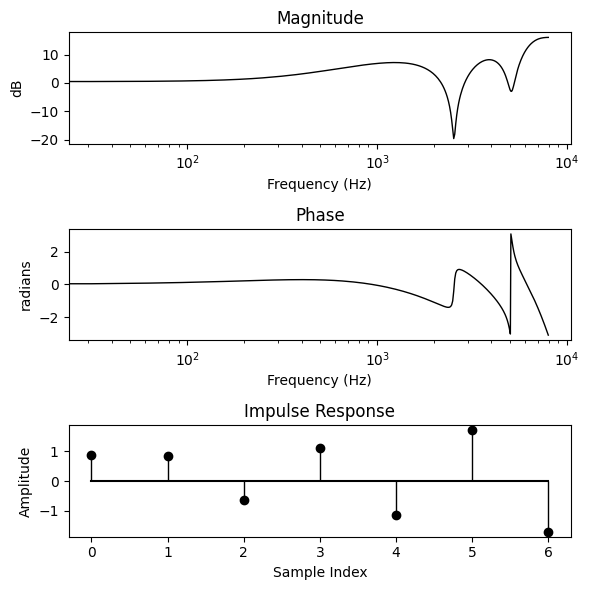

In [10]:
N = 512
M = 7
predicted_impulse_response = torch.randn(M, requires_grad=True)

bode_plot(predicted_impulse_response, N)

We define a synthetic target signal by creating a target filter... Let's make it something very obvious, alternating 1s and -1s.

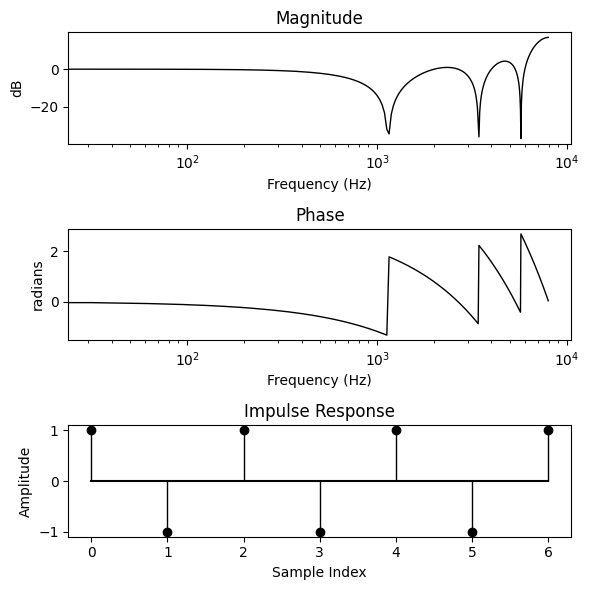

In [11]:
target_filter = torch.Tensor([1, -1, 1, -1, 1, -1, 1])
bode_plot(target_filter, N)

We define our target signal by applying the filter to some white noise.

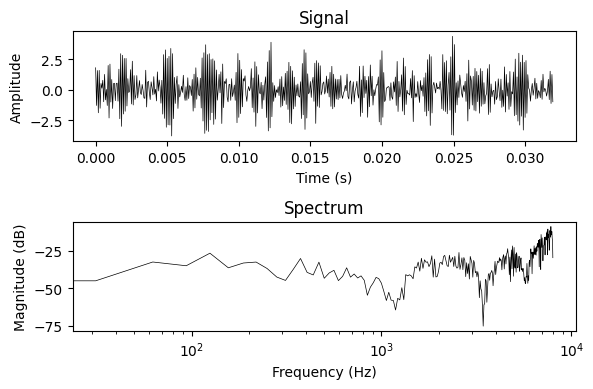

In [12]:
input_signal = torch.empty(N).uniform_(-1, 1)
target_signal = apply_conv1d_fir(input_signal, target_filter)

plot_signal_and_spectrum(target_signal)

Now we write a simple optimisation loop. Note that we are *applying the filter* to the noise signal in order to compute our loss. We are then taking a loss function between our target signal and the noise signal filtered by our predicted filter. This means there's no reason that we need to use $L^2$ loss --- we can use *any* loss function we can define on the signal.

In [13]:
optimizer = torch.optim.Adam([predicted_impulse_response], lr=1e-3)
criterion = nn.MSELoss()

steps = 7000
interval = 1000

for step in range(steps):
    predicted_signal = apply_conv1d_fir(input_signal, predicted_impulse_response)
    loss = criterion(target_signal, predicted_signal)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if step % interval == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

Step 0: loss 9.9219
Step 1000: loss 3.6533
Step 2000: loss 1.0294
Step 3000: loss 0.1894
Step 4000: loss 0.0173
Step 5000: loss 0.0004
Step 6000: loss 0.0000


Cool! That converged quickly. Let's plot the learnt response...

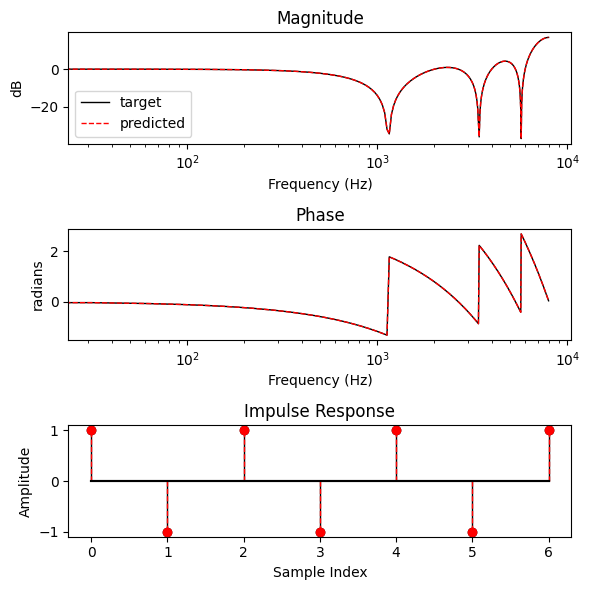

In [14]:
bode_plot([target_filter, predicted_impulse_response], N, labels=["target", "predicted"])

A perfect fit!